In [2]:
# Import Data handling/display libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Union, Dict
# put this lower down.....
sns.set()
sns.set_context("talk")

# Import scikit-learn core slibraries
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC as SVM

# Import IBM's AI Fairness tooolbox
from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms import Transformer
from aif360.algorithms.preprocessing import DisparateImpactRemover # Preprocessing technique

# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
train = pd.read_csv('./input/adult-clean.csv')
train.head(5)

,age,age_invalid_flag,fnlwgt,fnlwgt_invalid_flag,educational-num,educational-num_invalid_flag,capital-loss,capital-loss_invalid_flag,hours-per-week,hours-per-week_invalid_flag,...,income,income_invalid_flag,workclass,education,marital-status,occupation,relationship,race,gender,native-country
0,25.0,0,226802.0,0,7.0,0,0.0,0,40.0,0,...,0.0,0,0,0,0,0,0,0,0,0
1,38.0,0,89814.0,0,9.0,0,0.0,0,50.0,0,...,0.0,0,0,1,1,1,1,1,0,0
2,28.0,0,336951.0,0,12.0,0,0.0,0,40.0,0,...,1.0,0,1,2,1,2,1,1,0,0
3,44.0,0,160323.0,0,10.0,0,0.0,0,40.0,0,...,1.0,0,0,3,1,0,1,0,0,0
4,18.0,0,103497.0,0,10.0,0,0.0,0,30.0,0,...,0.0,0,0,3,0,3,0,1,1,0


In [4]:
X = train.drop("income",axis=1)
y = train["income"]
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 101, stratify=y)

from collections import Counter
print ('this is y_train Counter ()', Counter(y_train))
print('this is y_test Counter ()', Counter(y_test))
print('this is y_train unique', np.unique(y_train))
print('this is y_test  unique', np.unique(y_test))

this is y_train Counter () Counter({0.0: 3715, 1.0: 1169})
this is y_test Counter () Counter({0.0: 33440, 1.0: 10518})
this is y_train unique [0. 1.]
this is y_test  unique [0. 1.]


In [5]:
# Set a base line for Logistic Regression  
biasedlogmodel = LogisticRegression(random_state=101)
biasedlogmodel.fit(X_train,y_train)
logpredictions = biasedlogmodel.predict(X_test)
print(f"Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")
print(classification_report(y_test, logpredictions))
confusion_matrix(y_test, logpredictions)

Logistic regression validation accuracy: 0.7968970380818053
              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88     33440
         1.0       0.71      0.26      0.38     10518

    accuracy                           0.80     43958
   macro avg       0.76      0.61      0.63     43958
weighted avg       0.78      0.80      0.76     43958



array([[32301,  1139],
       [ 7789,  2729]], dtype=int64)

In [6]:
# Set a base line for Random Forest Classification
biasedrfcmodel = RandomForestClassifier(n_estimators=100,max_depth=5)
biasedrfcmodel.fit(X_train, y_train)
rfcpredictions = biasedrfcmodel.predict(X_test)
print(f"Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")
print(classification_report(y_test, rfcpredictions))
confusion_matrix(y_test, rfcpredictions)

Random forest validation accuracy: 0.8464443332271714
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91     33440
         1.0       0.81      0.47      0.59     10518

    accuracy                           0.85     43958
   macro avg       0.83      0.72      0.75     43958
weighted avg       0.84      0.85      0.83     43958



array([[32271,  1169],
       [ 5581,  4937]], dtype=int64)

In [7]:
# Create a Binary Label Dataset to use with AIF360 APIs
train_pp_bld = BinaryLabelDataset(df=pd.concat((X_train, y_train),
                                               axis=1),
                                  label_names=['income'],
                                  protected_attribute_names=['gender'],
                                  favorable_label=0,
                                  unfavorable_label=1)

privileged_groups = [{'gender': 0}]
unprivileged_groups = [{'gender': 1}]

In [8]:
class MetricAdditions:
    def explain(self,
                disp: bool=True) -> Union[None, str]:
        """Explain everything available for the given metric."""

        # Find intersecting methods/attributes between MetricTextExplainer and provided metric.
        inter = set(dir(self)).intersection(set(dir(self.metric)))

        # Ignore private and dunder methods
        metric_methods = [getattr(self, c) for c in inter if c.startswith('_') < 1]

        # Call methods, join to new lines
        s = "\n".join([f() for f in metric_methods if callable(f)])

        if disp:
            print(s)
        else:
            return s  
        
class MetricTextExplainer_(MetricTextExplainer, MetricAdditions):
    """Combine explainer and .explain."""
    pass

In [9]:
# Create the metric object from the Binary Label Dataset.
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print("# of instances  :", metric_train_bld.num_instances())
print("Base Rate       :", metric_train_bld.base_rate())
print("Consistency     :", metric_train_bld.consistency())
print("Disparate Impact:", metric_train_bld.disparate_impact())
print("Mean Difference :", metric_train_bld.mean_difference())
print("# of negatives(privileged)    :", metric_train_bld.num_negatives(privileged=True))
print("# of negatives(non-privileged):", metric_train_bld.num_negatives(privileged=False))
print("# of positives(privileged)    :", metric_train_bld.num_positives(privileged=True))
print("# of positives(non-privileged):", metric_train_bld.num_positives(privileged=False))
print("Statistical Parity Diference  :", metric_train_bld.statistical_parity_difference()) 
print("")
print("This is the explainer")
# Create the explainer object
explainer = MetricTextExplainer_(metric_train_bld)
# Explain relevant metrics
explainer.explain()

# of instances  : 4884.0
Base Rate       : 0.7606470106470107
Consistency     : [0.75249795]
Disparate Impact: 1.2588315565963069
Mean Difference : 0.18166779048027715
# of negatives(privileged)    : 985.0
# of negatives(non-privileged): 184.0
# of positives(privileged)    : 2319.0
# of positives(non-privileged): 1396.0
Statistical Parity Diference  : 0.18166779048027715

This is the explainer
Number of negative-outcome instances: 1169.0
Number of positive-outcome instances: 3715.0
Consistency (Zemel, et al. 2013): [0.75249795]
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.18166779048027715
Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): 0.18166779048027715
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.2588315565963069
Number of

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=False)

In [14]:
protected='gender'
#train, test = train_pp_bld.split([32561])
train, test = train_pp_bld.split(2)
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

In [18]:
from tqdm import tqdm
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.08it/s]


<IPython.core.display.Javascript object>


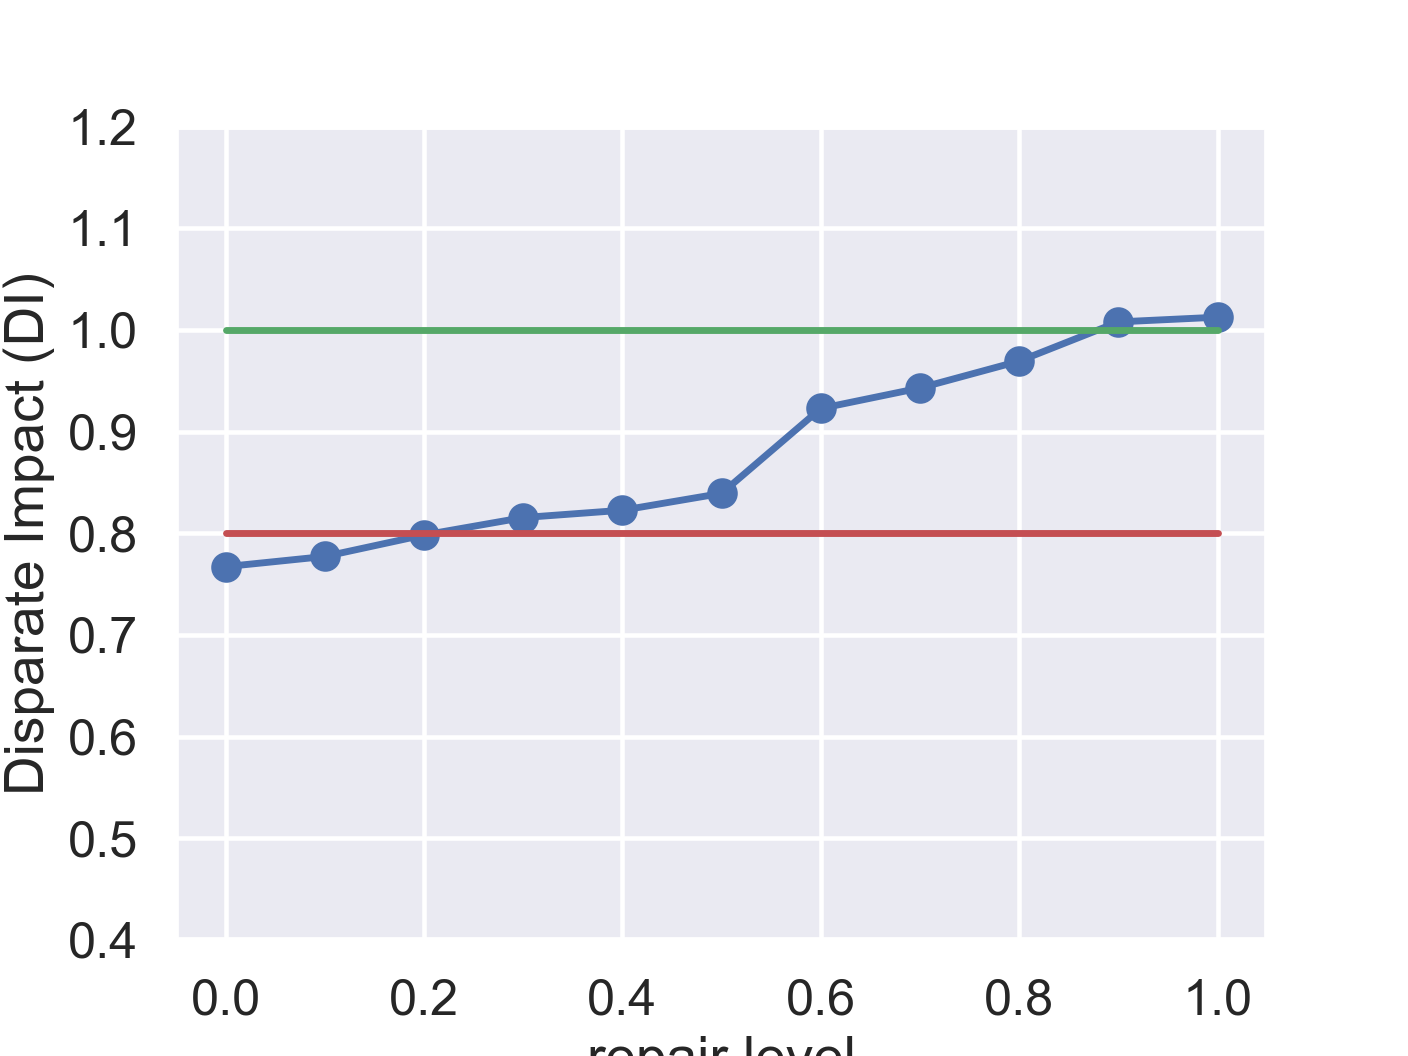

In [19]:
%matplotlib notebook

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

In [36]:
# I'm asuming where the plot meets the 0.8 (threshold) line is where we target, eg level = 0.2
# Set up an instance of the disparate remover object
di = DisparateImpactRemover(repair_level=0.2)
# fit the disparate remover on the original binary labelled dataset
di_removed = di.fit_transform(train_pp_bld)

In [34]:
# Now compare model accuracies
train_di_removed = di_removed.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
#train_di_removed
X = train_di_removed.drop("income",axis=1)
y = train_di_removed["income"]
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
#X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(X, y, test_size = 0.7, random_state = 101, stratify=y)

AttributeError: 'tuple' object has no attribute 'drop'

In [ ]:
# Use the new Dataframe 
unbiasedlogmodel = LogisticRegression()
unbiasedlogmodel.fit(X_di_train, y_di_train) #, sample_weight=train_pp_bld_f.instance_weights)
print(f"Biased   Logistic regression validation accuracy: {biasedlogmodel.score(X_test,y_test)}")
print(f"Unbiased Logistic regression validation accuracy: {unbiasedlogmodel.score(X_di_test, y_di_test)}")

In [ ]:
unbiasedrfcmodel = RandomForestClassifier(n_estimators=100, max_depth=5)
unbiasedrfcmodel.fit(X_di_train, y_di_train) #, sample_weight=train_pp_bld_f.instance_weights)
print(f"Biased   Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")
print(f"Unbiased Random forest validation accuracy: {unbiasedrfcmodel.score(X_di_test, y_di_test)}")

In [ ]:
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray],
             title: str='', 
             ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, 
                          y=tpr,
                          ci=None,
                          ax=ax
                         )
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1],
                 y=[0, 1],
                 color='gray',
                 ax=ax)
    
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [biasedlogmodel.score(X_test, y_test), 
                                 unbiasedlogmodel.score(X_test, y_test)],
                      'RFC': [biasedrfcmodel.score(X_test, y_test),
                              unbiasedrfcmodel.score(X_test, y_test)]}, 
                     index =['Unfair', 'Fair']))

print('AUC:')
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
plot_auc(y_test, 
         {'biased': biasedlogmodel.predict_proba(X_test)[:, 1],
          'unbiased': unbiasedlogmodel.predict_proba(X_test)[:, 1]},
         title='LR',
         ax=ax[0]) 
plot_auc(y_test, 
         {'biased': biasedrfcmodel.predict_proba(X_test)[:, 1],
          'unbiased': unbiasedrfcmodel.predict_proba(X_test)[:, 1]},
         title='RFC',
         ax=ax[1]) 
plt.show()

In [ ]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

In [ ]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR Feature Importance - before Mitigating')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedrfcmodel,
                                                names=X_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC Feature Importance - before Mitigating')

In [ ]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR Feature Importance - after Mitigating')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiasedrfcmodel,
                                                names=X_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC Feature Importance - after Mitigating')

In [ ]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true),
                                               axis=1),
                                  label_names=['income'],
                                  protected_attribute_names=['gender'],
                                  favorable_label=0,
                                  unfavorable_label=1)

    privileged_groups = [{'gender': 0}]
    unprivileged_groups = [{'gender': 1}]
    
    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy = []
    balanced_accuracy = []
    disp_impact = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

In [ ]:
# Plot for LR
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biasedlogmodel, X_test, y_test),
                ax=ax[0],
                title="LR: Biased")
    
    plot_metrics(calc_metrics(unbiasedlogmodel, X_test, y_test),
                ax=ax[1],
                title='"LR: Fair"')

In [ ]:
# Plot for RFC
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biasedrfcmodel, X_test, y_test),
                ax=ax[0],
                title="RFC: Biased")
    
    plot_metrics(calc_metrics(unbiasedrfcmodel, X_test, y_test),
                ax=ax[1],
                title='"RFC: Fair"')